In [2]:
import pandas as pd

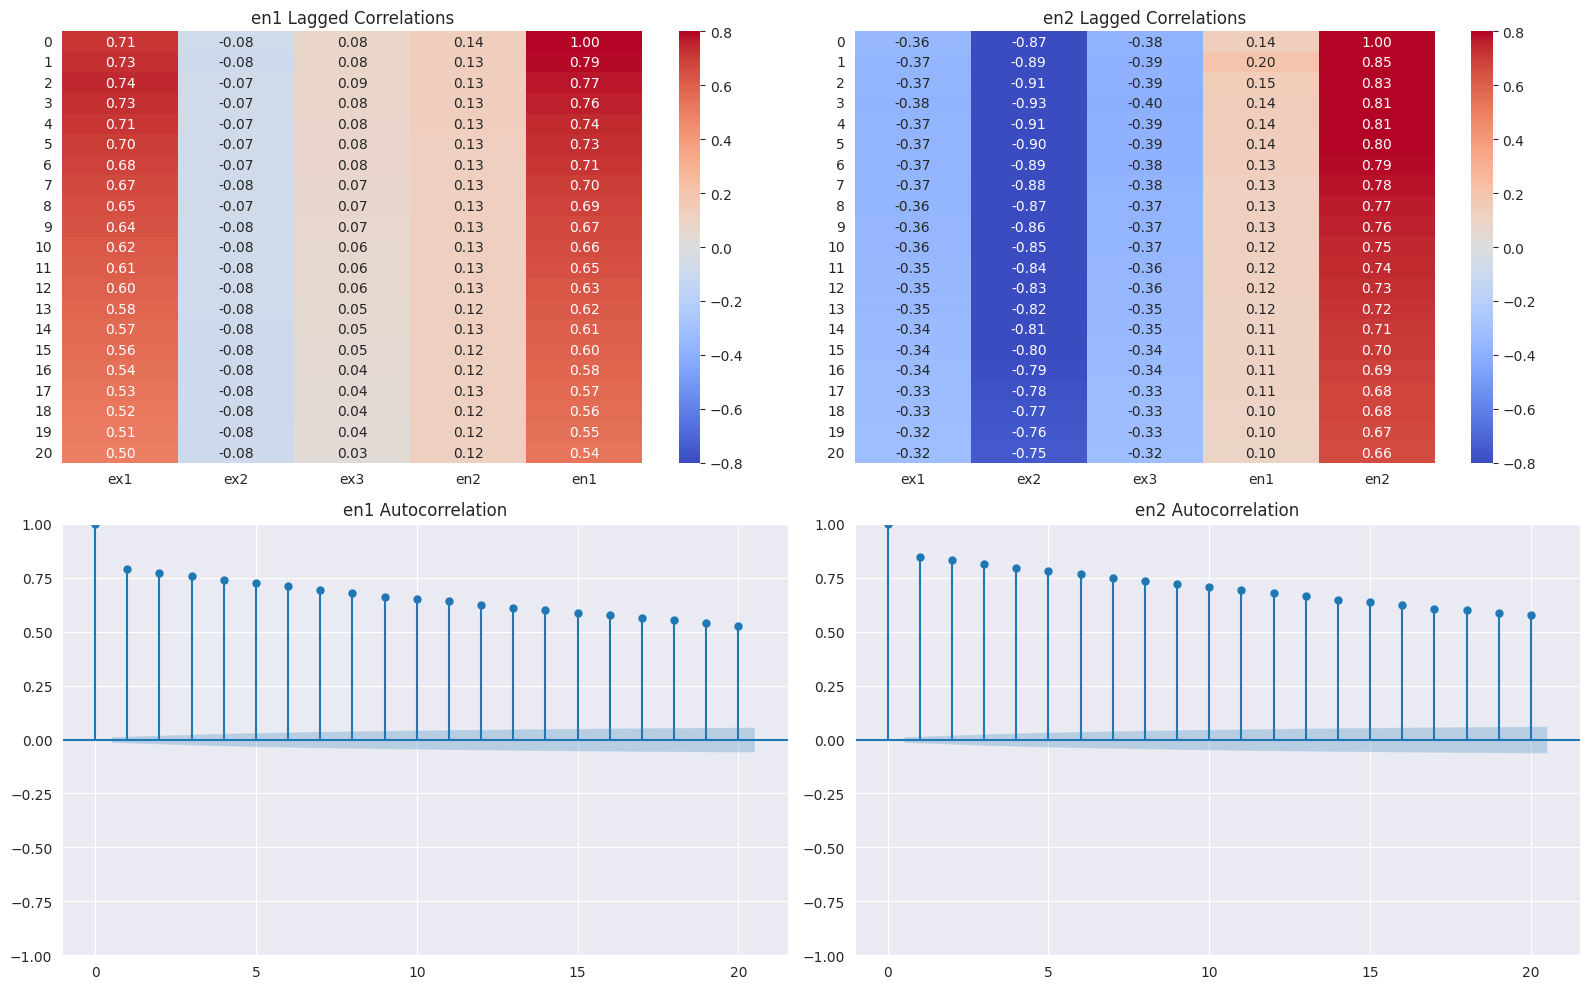

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler

# ----- Clean Synthetic Data Generation -----
np.random.seed(42)
n = 20000  # Number of time steps

# Create base signals with controlled autocorrelation
def create_signal(base_value, noise_scale, n):
    signal = np.zeros(n)
    signal[0] = base_value + np.random.normal(0, noise_scale)
    for t in range(1, n):
        signal[t] = 0.98 * signal[t-1] + np.random.normal(0, noise_scale * 0.3)
    return signal

# Generate exogenous variables
ex1 = create_signal(10, 0.3, n)
ex2 = create_signal(20, 0.4, n)
ex3 = create_signal(15, 0.5, n)

# Create DataFrame
df = pd.DataFrame({
    'ex1': ex1,
    'ex2': ex2,
    'ex3': ex3
})

# Standardize exogenous variables
scaler = StandardScaler()
df[['ex1', 'ex2', 'ex3']] = scaler.fit_transform(df[['ex1', 'ex2', 'ex3']])

# Generate endogenous variables with specified lagged relationships
def create_endogenous(lagged_signals, coefficients, noise_scale):
    n = len(df)
    signal = np.zeros(n)
    max_lag = max([l for _, l in lagged_signals])

    # Initialize early values with minimal noise
    for t in range(max_lag):
        signal[t] = np.random.normal(0, noise_scale * 0.5)

    # Create with specified lagged dependencies (positive or negative)
    for t in range(max_lag, n):
        weighted_sum = 0
        for (signal_idx, lag), coeff in zip(lagged_signals, coefficients):
            weighted_sum += coeff * df.iloc[t - lag, signal_idx]
        signal[t] = weighted_sum + np.random.normal(0, noise_scale)
    return signal

# en1: High positive with ex1 (lag 2), medium negative with ex2 (lag 1), minimal with ex3, medium with en2
df['en1'] = create_endogenous(
    lagged_signals=[(0, 2), (1, 1), (2, 1)],  # ex1, ex2, ex3 only
    coefficients=[0.7, -0.4, 0.0],
    noise_scale=0.3
)

# en2: Medium with en1 (lag 1), small negative with ex1 (lag 2), high negative with ex2 (lag 3), minimal with ex3
df['en2'] = create_endogenous(
    lagged_signals=[(3, 1), (0, 2), (1, 3), (2, 1)],  # en1, ex1, ex2, ex3
    coefficients=[0.4, -0.2, -0.7, 0.0],  # Medium, small negative, high negative, minimal
    noise_scale=0.3
)

# Standardize endogenous variables
df[['en1', 'en2']] = scaler.fit_transform(df[['en1', 'en2']])

# ----- Lagged Correlation Calculation -----
lags = range(0, 21)
cols_en1 = ['ex1', 'ex2', 'ex3', 'en2', 'en1']
cols_en2 = ['ex1', 'ex2', 'ex3', 'en1', 'en2']

results_en1 = pd.DataFrame(index=lags, columns=cols_en1)
results_en2 = pd.DataFrame(index=lags, columns=cols_en2)

for lag in lags:
    for col in cols_en1:
        shifted = df[col].shift(lag)
        valid_idx = shifted.notna() & df['en1'].notna()
        results_en1.loc[lag, col] = df['en1'][valid_idx].corr(shifted[valid_idx]) if valid_idx.any() else 0
    for col in cols_en2:
        shifted = df[col].shift(lag)
        valid_idx = shifted.notna() & df['en2'].notna()
        results_en2.loc[lag, col] = df['en2'][valid_idx].corr(shifted[valid_idx]) if valid_idx.any() else 0

# Convert results to float
results_en1 = results_en1.astype(float)
results_en2 = results_en2.astype(float)

# ----- Visualization -----
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Heatmaps
sns.heatmap(results_en1, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-0.8, vmax=0.8, ax=axes[0,0])
axes[0,0].set_title("en1 Lagged Correlations")
sns.heatmap(results_en2, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-0.8, vmax=0.8, ax=axes[0,1])
axes[0,1].set_title("en2 Lagged Correlations")

# ACF Plots
plot_acf(df['en1'], lags=20, ax=axes[1,0], title='en1 Autocorrelation')
plot_acf(df['en2'], lags=20, ax=axes[1,1], title='en2 Autocorrelation')

plt.tight_layout()
plt.show()

In [3]:
df.to_csv("dataset/synthetic/synthetic.csv", index=False)

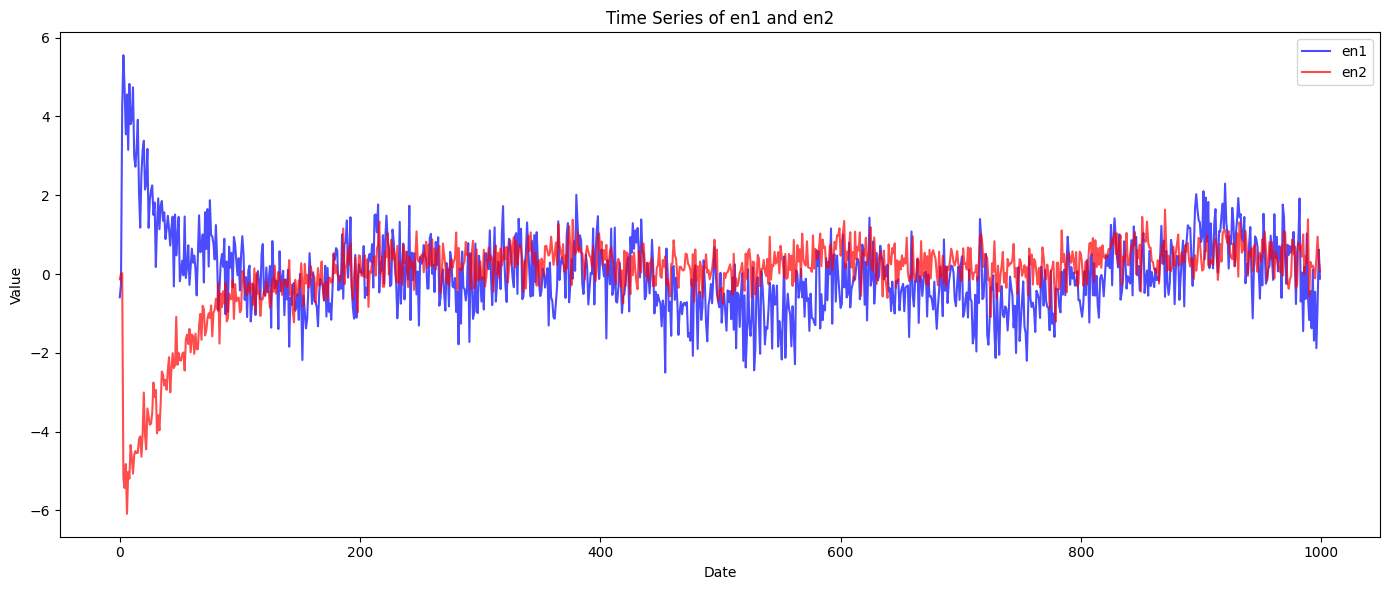

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already defined in the environment
# Plotting the time series for en1 and en2
plt.figure(figsize=(14, 6))

# Plot en1 and en2 over time
plt.plot(df.index, df['en1'], label='en1', color='blue', alpha=0.7)
plt.plot(df.index, df['en2'], label='en2', color='red', alpha=0.7)
#plt.plot(df.index, df['ex1'], label='ex1', color='green', alpha=0.7)
#plt.plot(df.index, df['ex2'], label='ex2', color='yellow', alpha=0.7)
#plt.plot(df.index, df['ex3'], label='ex3', color='black', alpha=0.7)

# Adding titles and labels
plt.title('Time Series of en1 and en2')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [28]:
df.to_csv('synthetic_times_series.csv')

2020-01-04    7.607058
2020-01-05    5.648529
2020-01-06    3.315111
2020-01-07    5.771844
2020-01-08    2.276639
                ...   
2022-09-22    4.295994
2022-09-23    0.881898
2022-09-24    3.818916
2022-09-25    7.679803
2022-09-26    6.119159
Freq: D, Name: en1, Length: 997, dtype: float64

In [36]:
df_weather = pd.read_csv('dataset/EPF/DE.csv')
df_weather

,date,Wind power forecast,Ampirion zonal load forecast,OT
0,2012/1/9 0:00,2072.00,16382.00,34.97
1,2012/1/9 1:00,1929.75,15410.50,33.43
2,2012/1/9 2:00,1856.00,15595.00,32.74
3,2012/1/9 3:00,1808.75,16521.00,32.46
4,2012/1/9 4:00,1765.75,17700.75,32.50
...,...,...,...,...
52411,2017/12/31 19:00,1300.00,16601.00,7.92
52412,2017/12/31 20:00,1261.00,15977.75,4.06
52413,2017/12/31 21:00,1243.25,15715.00,5.30
52414,2017/12/31 22:00,1250.50,15876.00,1.86


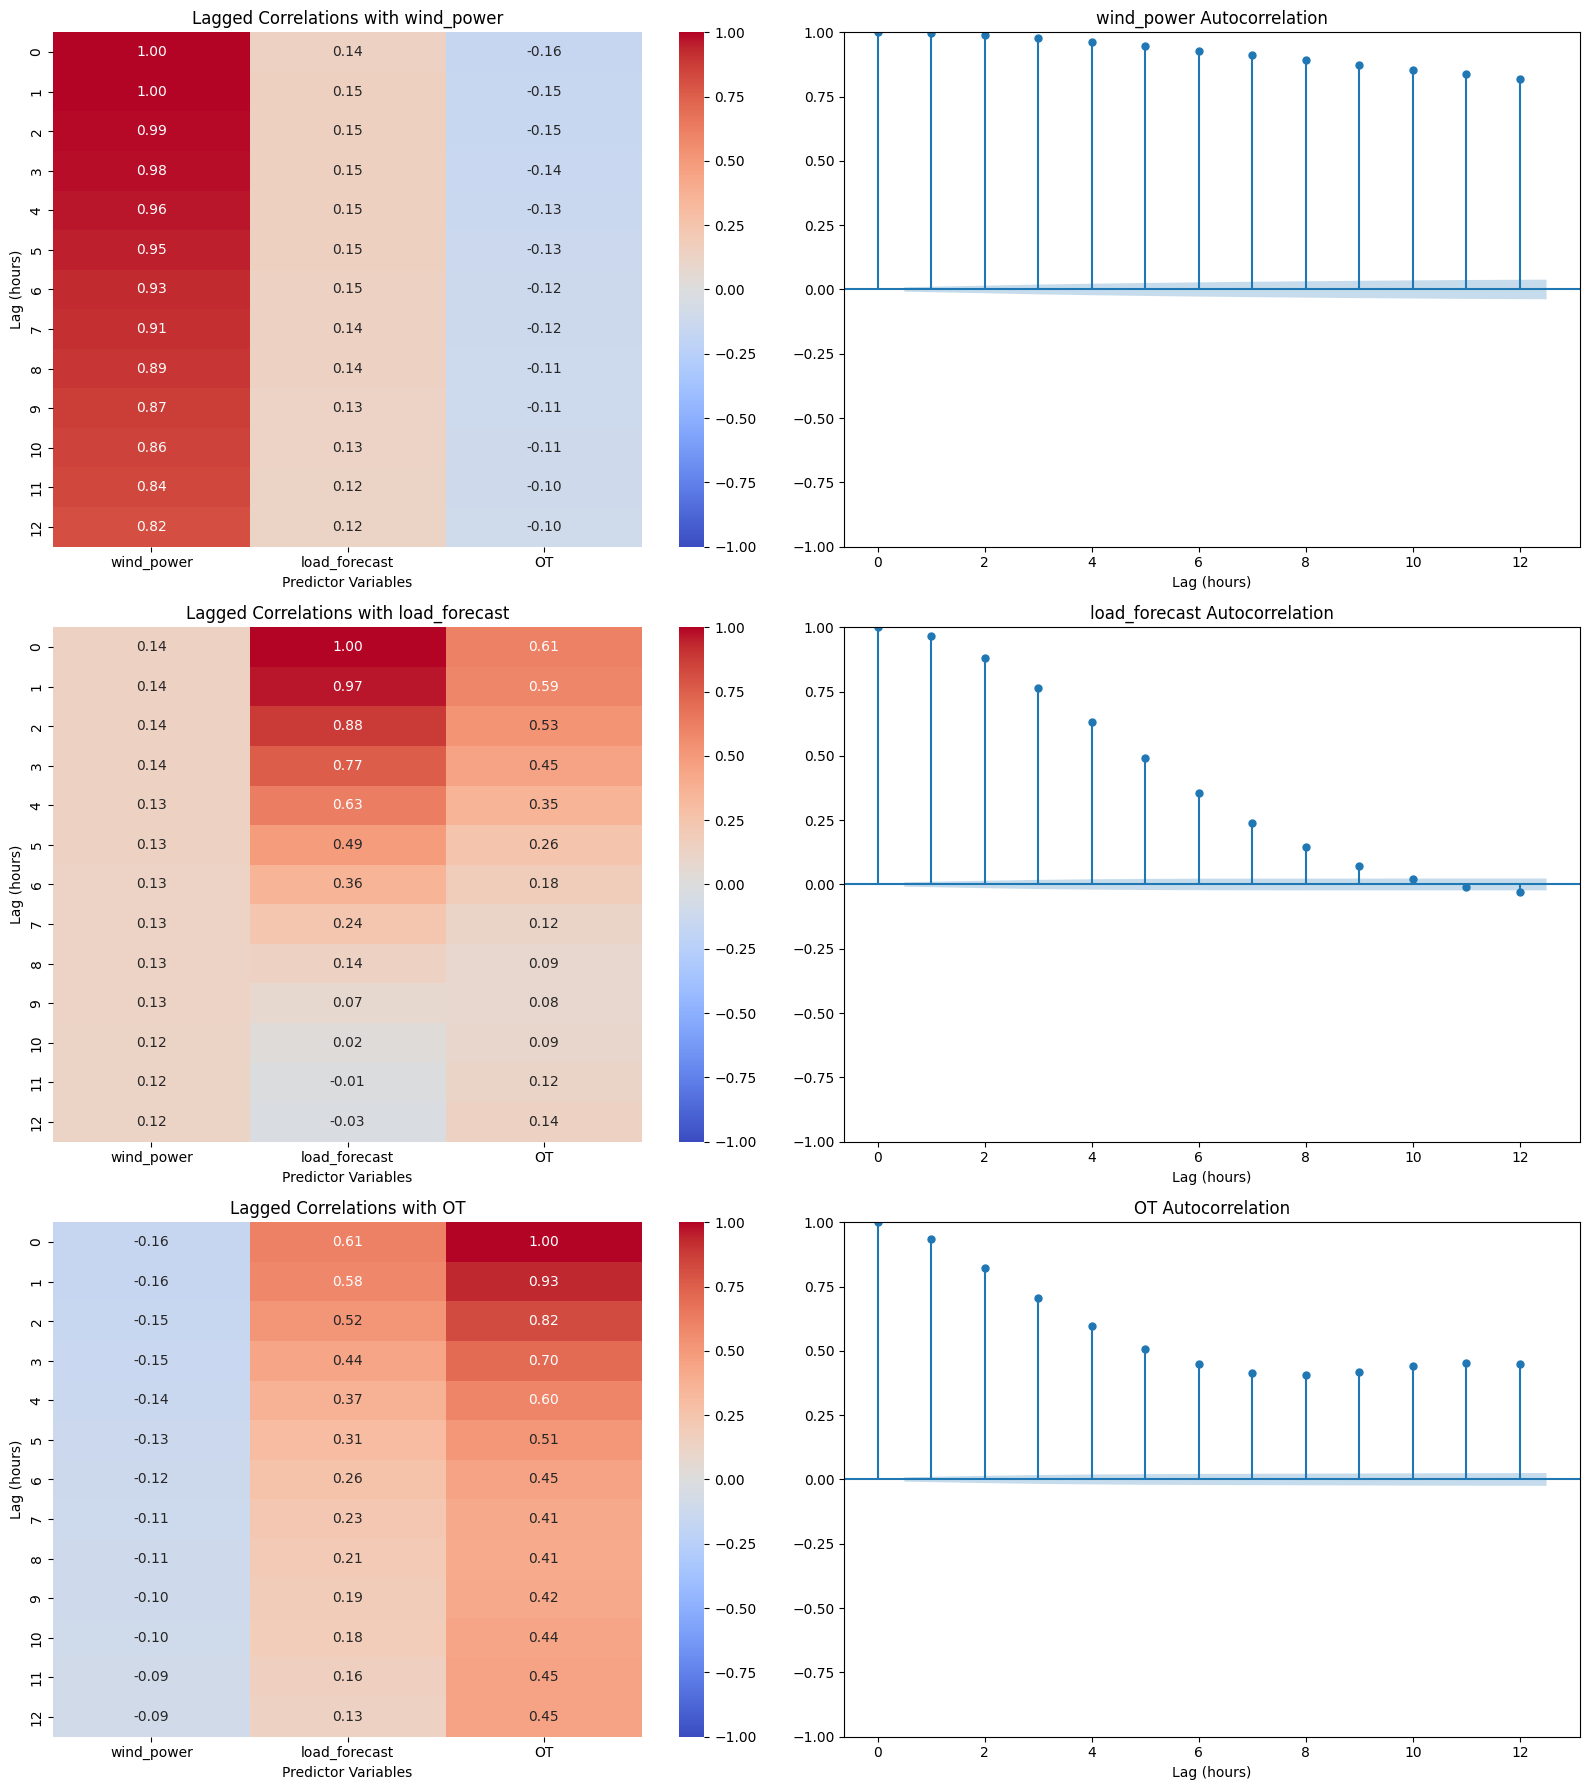

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Load your data (replace 'energy_data.csv' with your actual file path)
df = pd.read_csv('dataset/EPF/DE.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Rename columns for cleaner visualization (optional)
df.columns = ['wind_power', 'load_forecast', 'OT']

# ----- Lagged Correlation Calculation -----
lags = range(0, 13)  # 12 lags (hours) for hourly data
variables = df.columns.tolist()

# Initialize results DataFrames
results = {var: pd.DataFrame(index=lags, columns=variables) for var in variables}

# Calculate correlations
for target_var in variables:
    for lag in lags:
        for predictor_var in variables:
            # Pearson correlation at each lag
            results[target_var].loc[lag, predictor_var] = \
                df[predictor_var].shift(lag).corr(df[target_var])

    # Convert to float
    results[target_var] = results[target_var].astype(float)

# ----- Visualization -----
fig, axes = plt.subplots(len(variables), 2, figsize=(16, 6*len(variables)))

for i, target_var in enumerate(variables):
    # Heatmap
    sns.heatmap(results[target_var], annot=True, fmt=".2f", cmap='coolwarm',
               center=0, vmin=-1, vmax=1, ax=axes[i,0])
    axes[i,0].set_title(f"Lagged Correlations with {target_var}")
    axes[i,0].set_xlabel("Predictor Variables")
    axes[i,0].set_ylabel("Lag (hours)")

    # ACF Plot
    plot_acf(df[target_var], lags=12, ax=axes[i,1],
             title=f'{target_var} Autocorrelation')
    axes[i,1].set_xlabel("Lag (hours)")

plt.tight_layout()
plt.show()